<a href="https://colab.research.google.com/github/Veldora00/Veldora00/blob/main/BHPwithearnings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%%**********************]  1 of 1 completed


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Hyperparameters: {'alpha': 0.1, 'colsample_bytree': 0.6, 'lambda': 1, 'learning_rate': 0.06, 'max_depth': 9, 'n_estimators': 1200, 'subsample': 0.9}
Cross-Validation R^2 Scores: [0.99861105 0.99851219 0.99872246 0.99837416 0.99871006]
Mean Cross-Validation R^2 Score: 0.9985859862208928
Training Mean Squared Error: 0.0004949364221091251
Test Mean Squared Error: 0.6222089415227515
Training R^2 Score: 0.9999991349329977
Test R^2 Score: 0.9988690368244457


<ipython-input-2-66ca3838b824>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day'] = data.index.day
<ipython-input-2-66ca3838b824>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month'] = data.index.month
<ipython-input-2-66ca3838b824>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.h

Horizon: 252 days
Mean Squared Error: 2.8852574768689734
R^2 Score: 0.6823286292028313

Horizon: 504 days
Mean Squared Error: 7.142995413641319
R^2 Score: 0.7253370046067664

Horizon: 756 days
Mean Squared Error: 7.477592221208156
R^2 Score: 0.788825545085031



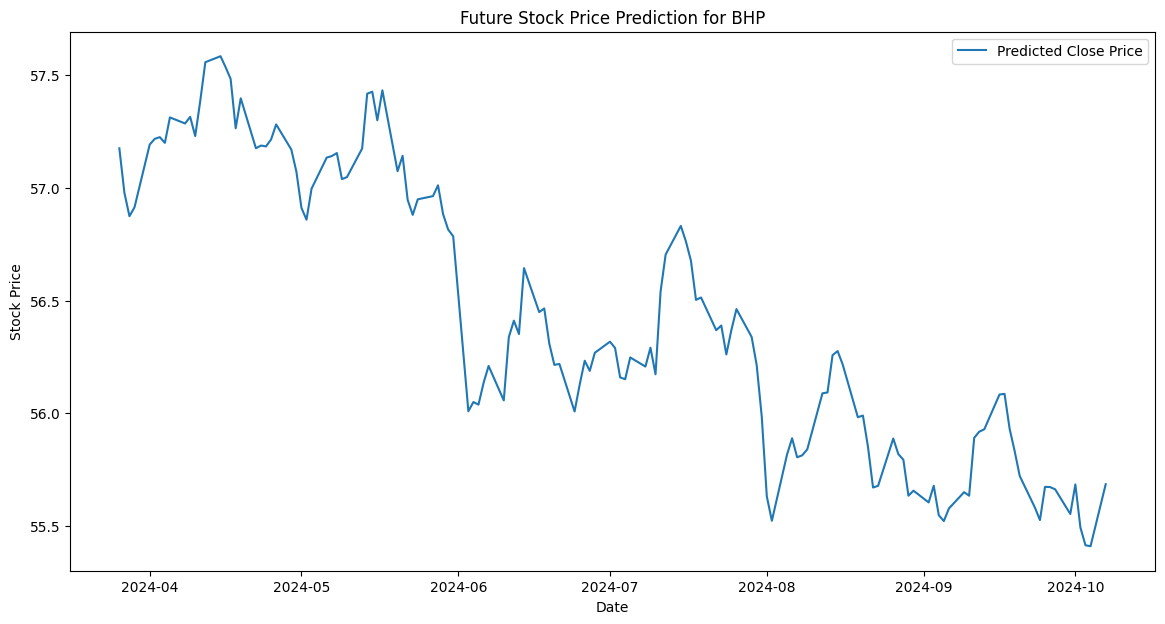

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import matplotlib.pyplot as plt

# Step 1: Fetch Historical Data
def fetch_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data[['Close', 'Volume']]
    stock_data = stock_data.dropna()
    stock_data.index = stock_data.index.tz_localize(None)  # Ensure datetime index is timezone-naive
    return stock_data

# Step 2: Fetch Earnings Data
def fetch_earnings_data(ticker):
    ticker_obj = yf.Ticker(ticker)
    earnings = ticker_obj.earnings_dates
    earnings['Earnings_Flag'] = 1
    earnings['Date'] = earnings.index.tz_localize(None)  # Ensure datetime index is timezone-naive
    earnings.index = earnings.index.tz_localize(None)  # Ensure the index is timezone-naive
    return earnings

# Step 3: Enhanced Feature Engineering
def create_features(data, earnings_data):
    data['Day'] = data.index.day
    data['Month'] = data.index.month
    data['Year'] = data.index.year
    data['Day_of_Week'] = data.index.dayofweek
    data['MA_10'] = data['Close'].rolling(window=10).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()
    data['MA_100'] = data['Close'].rolling(window=100).mean()
    data['MA_200'] = data['Close'].rolling(window=200).mean()
    data['Volatility'] = data['Close'].rolling(window=10).std()
    data['Volume'] = data['Volume']

    # Merge earnings data
    data = data.merge(earnings_data[['Date', 'Earnings_Flag']], how='left', left_index=True, right_on='Date')
    data['Earnings_Flag'] = data['Earnings_Flag'].fillna(0)
    data = data.drop(columns=['Date'])

    # Filling NaN values
    data.fillna(method='bfill', inplace=True)

    X = data[['Day', 'Month', 'Year', 'Day_of_Week', 'MA_10', 'MA_50', 'MA_100', 'MA_200', 'Volatility', 'Volume', 'Earnings_Flag']]
    y = data['Close']
    return X, y

# Step 4: Hyperparameter Tuning with XGBoost
def tune_hyperparameters(X_train, y_train):
    param_grid = {
        'n_estimators': [900, 1100, 1200],
        'max_depth': [9],
        'learning_rate': [0.06],
        'subsample': [0.9],
        'colsample_bytree': [0.6],
        'alpha': [0, 0.1, 1],  # L1 regularization term on weights
        'lambda': [1, 0.1, 0.01]  # L2 regularization term on weights
    }
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    print(f"Best Hyperparameters: {grid_search.best_params_}")
    return grid_search.best_estimator_

# Step 5: Model Training
def train_model(X_train, y_train):
    model = tune_hyperparameters(X_train, y_train)
    model.fit(X_train, y_train)
    return model

# Step 6: Model Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    print(f"Training Mean Squared Error: {train_mse}")
    print(f"Test Mean Squared Error: {test_mse}")
    print(f"Training R^2 Score: {train_r2}")
    print(f"Test R^2 Score: {test_r2}")

    return y_test_pred

# Step 7: Prepare Future Data and Predict
def prepare_future_data(last_date, days=252*2):
    future_dates = pd.date_range(start=last_date, periods=days, freq='B')  # Business days
    future_data = pd.DataFrame(index=future_dates)
    future_data['Day'] = future_data.index.day
    future_data['Month'] = future_data.index.month
    future_data['Year'] = future_data.index.year
    future_data['Day_of_Week'] = future_data.index.dayofweek
    future_data['Earnings_Flag'] = 0  # Default value for future earnings flag
    return future_data

def predict_future(model, past_data, future_data):
    for ma in ['MA_10', 'MA_50', 'MA_100', 'MA_200']:
        future_data[ma] = past_data['Close'].rolling(window=int(ma.split('_')[1])).mean().iloc[-1]

    future_data['Volatility'] = past_data['Close'].rolling(window=10).std().iloc[-1]
    future_data['Volume'] = past_data['Volume'].iloc[-1]
    future_data.fillna(method='bfill', inplace=True)

    X_future = future_data[['Day', 'Month', 'Year', 'Day_of_Week', 'MA_10', 'MA_50', 'MA_100', 'MA_200', 'Volatility', 'Volume', 'Earnings_Flag']]
    future_data['Predicted_Close'] = model.predict(X_future)
    return future_data

# Cross-Validation
def cross_validate_model(model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    print(f"Cross-Validation R^2 Scores: {scores}")
    print(f"Mean Cross-Validation R^2 Score: {scores.mean()}")

# Assess Future Prediction Accuracy
def assess_future_accuracy(model, data, earnings_data, horizons):
    results = {}
    for horizon in horizons:
        # Split the data
        train_data = data[:-horizon]
        test_data = data[-horizon:]

        # Ensure the earnings data aligns with the training data
        earnings_train = earnings_data[earnings_data.index <= train_data.index[-1]]

        # Create features
        X_train, y_train = create_features(train_data, earnings_train)
        X_test, y_test = create_features(test_data, earnings_train)

        # Train model on the training set
        model.fit(X_train, y_train)

        # Predict and evaluate on the test set
        y_test_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_test_pred)
        r2 = r2_score(y_test, y_test_pred)

        # Store the metrics
        results[horizon] = {'MSE': mse, 'R2': r2}

    return results

# Main function to run the pipeline
def main():
    # Fetch data
    today = "2024-03-27"
    data = fetch_data('BHP', start_date="1981-01-01", end_date=today)
    earnings_data = fetch_earnings_data('BHP')
    last_date = data.index[-1]

    # Prepare and split data
    X, y = create_features(data, earnings_data)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = train_model(X_train, y_train)

    # Cross-Validate model
    cross_validate_model(model, X_train, y_train)

    # Evaluate model
    test_indices = X_test.index.intersection(data.index)
    test_data = data.loc[test_indices]
    evaluate_model(model, X_train, y_train, X_test, y_test)

    # Assess future prediction accuracy
    horizons = [252, 504, 756]  # Test 1 year, 2 years, 3 years into the future
    future_accuracy = assess_future_accuracy(model, data, earnings_data, horizons)
    for horizon, metrics in future_accuracy.items():
        print(f"Horizon: {horizon} days")
        print(f"Mean Squared Error: {metrics['MSE']}")
        print(f"R^2 Score: {metrics['R2']}\n")

    # Prepare future data and make predictions
    future_data = prepare_future_data(last_date, days=140)  # Predicting for next 2 years (252 trading days per year)
    predicted_future_data = predict_future(model, data, future_data)

    # Save predictions to CSV
    predicted_future_data.to_csv('predicted_future_prices.csv')

    # Plot future predictions
    plt.figure(figsize=(14, 7))
    plt.plot(predicted_future_data.index, predicted_future_data['Predicted_Close'], label='Predicted Close Price')
    plt.title('Future Stock Price Prediction for BHP')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

    print("Predictions saved to 'predicted_future_prices.csv'")

# Run the main function
main()